In [1]:
import networkx as nx
from neo4j import GraphDatabase
import pandas as pd
from pyvis.network import Network
import matplotlib.pyplot as plt
driver = GraphDatabase.driver('bolt://neo4j:7687', auth=("neo4j", "BDII2023"))
session = driver.session()
def run_query(query, return_data=True, **kwargs):
        results = session.run(query, kwargs)
        if return_data:
            return results.data()
        return results

### 1. **Mapamundi**: El mapamundi debe mostrar las distintas áreas del juego y como se interconectan unas con otras.


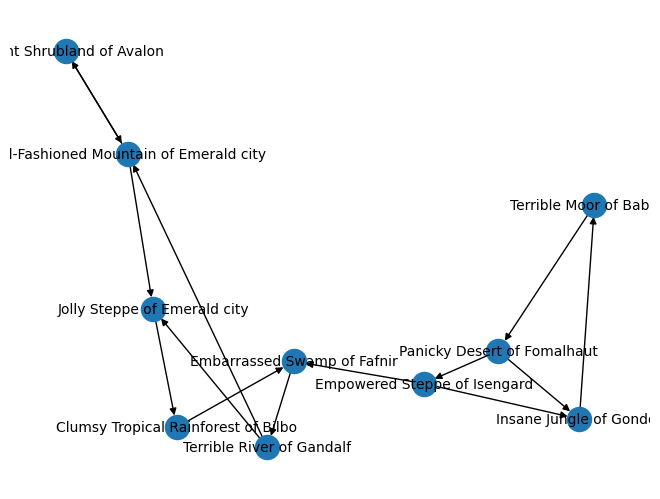

In [2]:
# Make a networkx graph from the neo4j graph
# (a1: Area)-[:SHORTEST_PATH]->(a2: Area)
query = """
MATCH (a1:Area)-[r:SHORTEST_PATH]->(a2:Area)
RETURN a1.name as source, a2.name as target, r.length as length
"""
data = run_query(query)
G = nx.DiGraph()
for row in data:
    G.add_edge(row['source'], row['target'], weight=row['length'])

# Set the position of each node
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, pos=pos, font_size=10)

In [3]:
# To each node, add the property 'x' and 'y' with the position
for node in G.nodes:
    G.nodes[node]['x'] = pos[node][0]
    G.nodes[node]['y'] = pos[node][1]
    G.nodes[node]['title'] = str(node)
# Use pyvis to visualize the graph
from pyvis.network import Network
net = Network(notebook=True, directed=True)
# Use the networkx graph to create the pyvis graph. Make sure to use the same layout
net.from_nx(G)
for node in net.nodes:
    node['label']=""
net.options.interaction.hover = True
net.show('graph.html', notebook=True)

graph.html


In [4]:
for node in G.nodes:
    print(node)

Jolly Steppe of Emerald city
Clumsy Tropical Rainforest of Bilbo
Uptight Shrubland of Avalon
Old-Fashioned Mountain of Emerald city
Insane Jungle of Gondor
Terrible Moor of Babylon
Embarrassed Swamp of Fafnir
Terrible River of Gandalf
Empowered Steppe of Isengard
Panicky Desert of Fomalhaut


In [5]:
# Get number of edges
print("Number of edges:", G.number_of_edges())

Number of edges: 14


### 2. **Listado mazmorras**: El listado de mazmorras debe mostrar todas las mazmorras del juego y las áreas con las que están conectadas. Debería ser capaz de ver a simple vista que mazmorras están en cada área y mazmorras hacen de puente entre dos áreas.


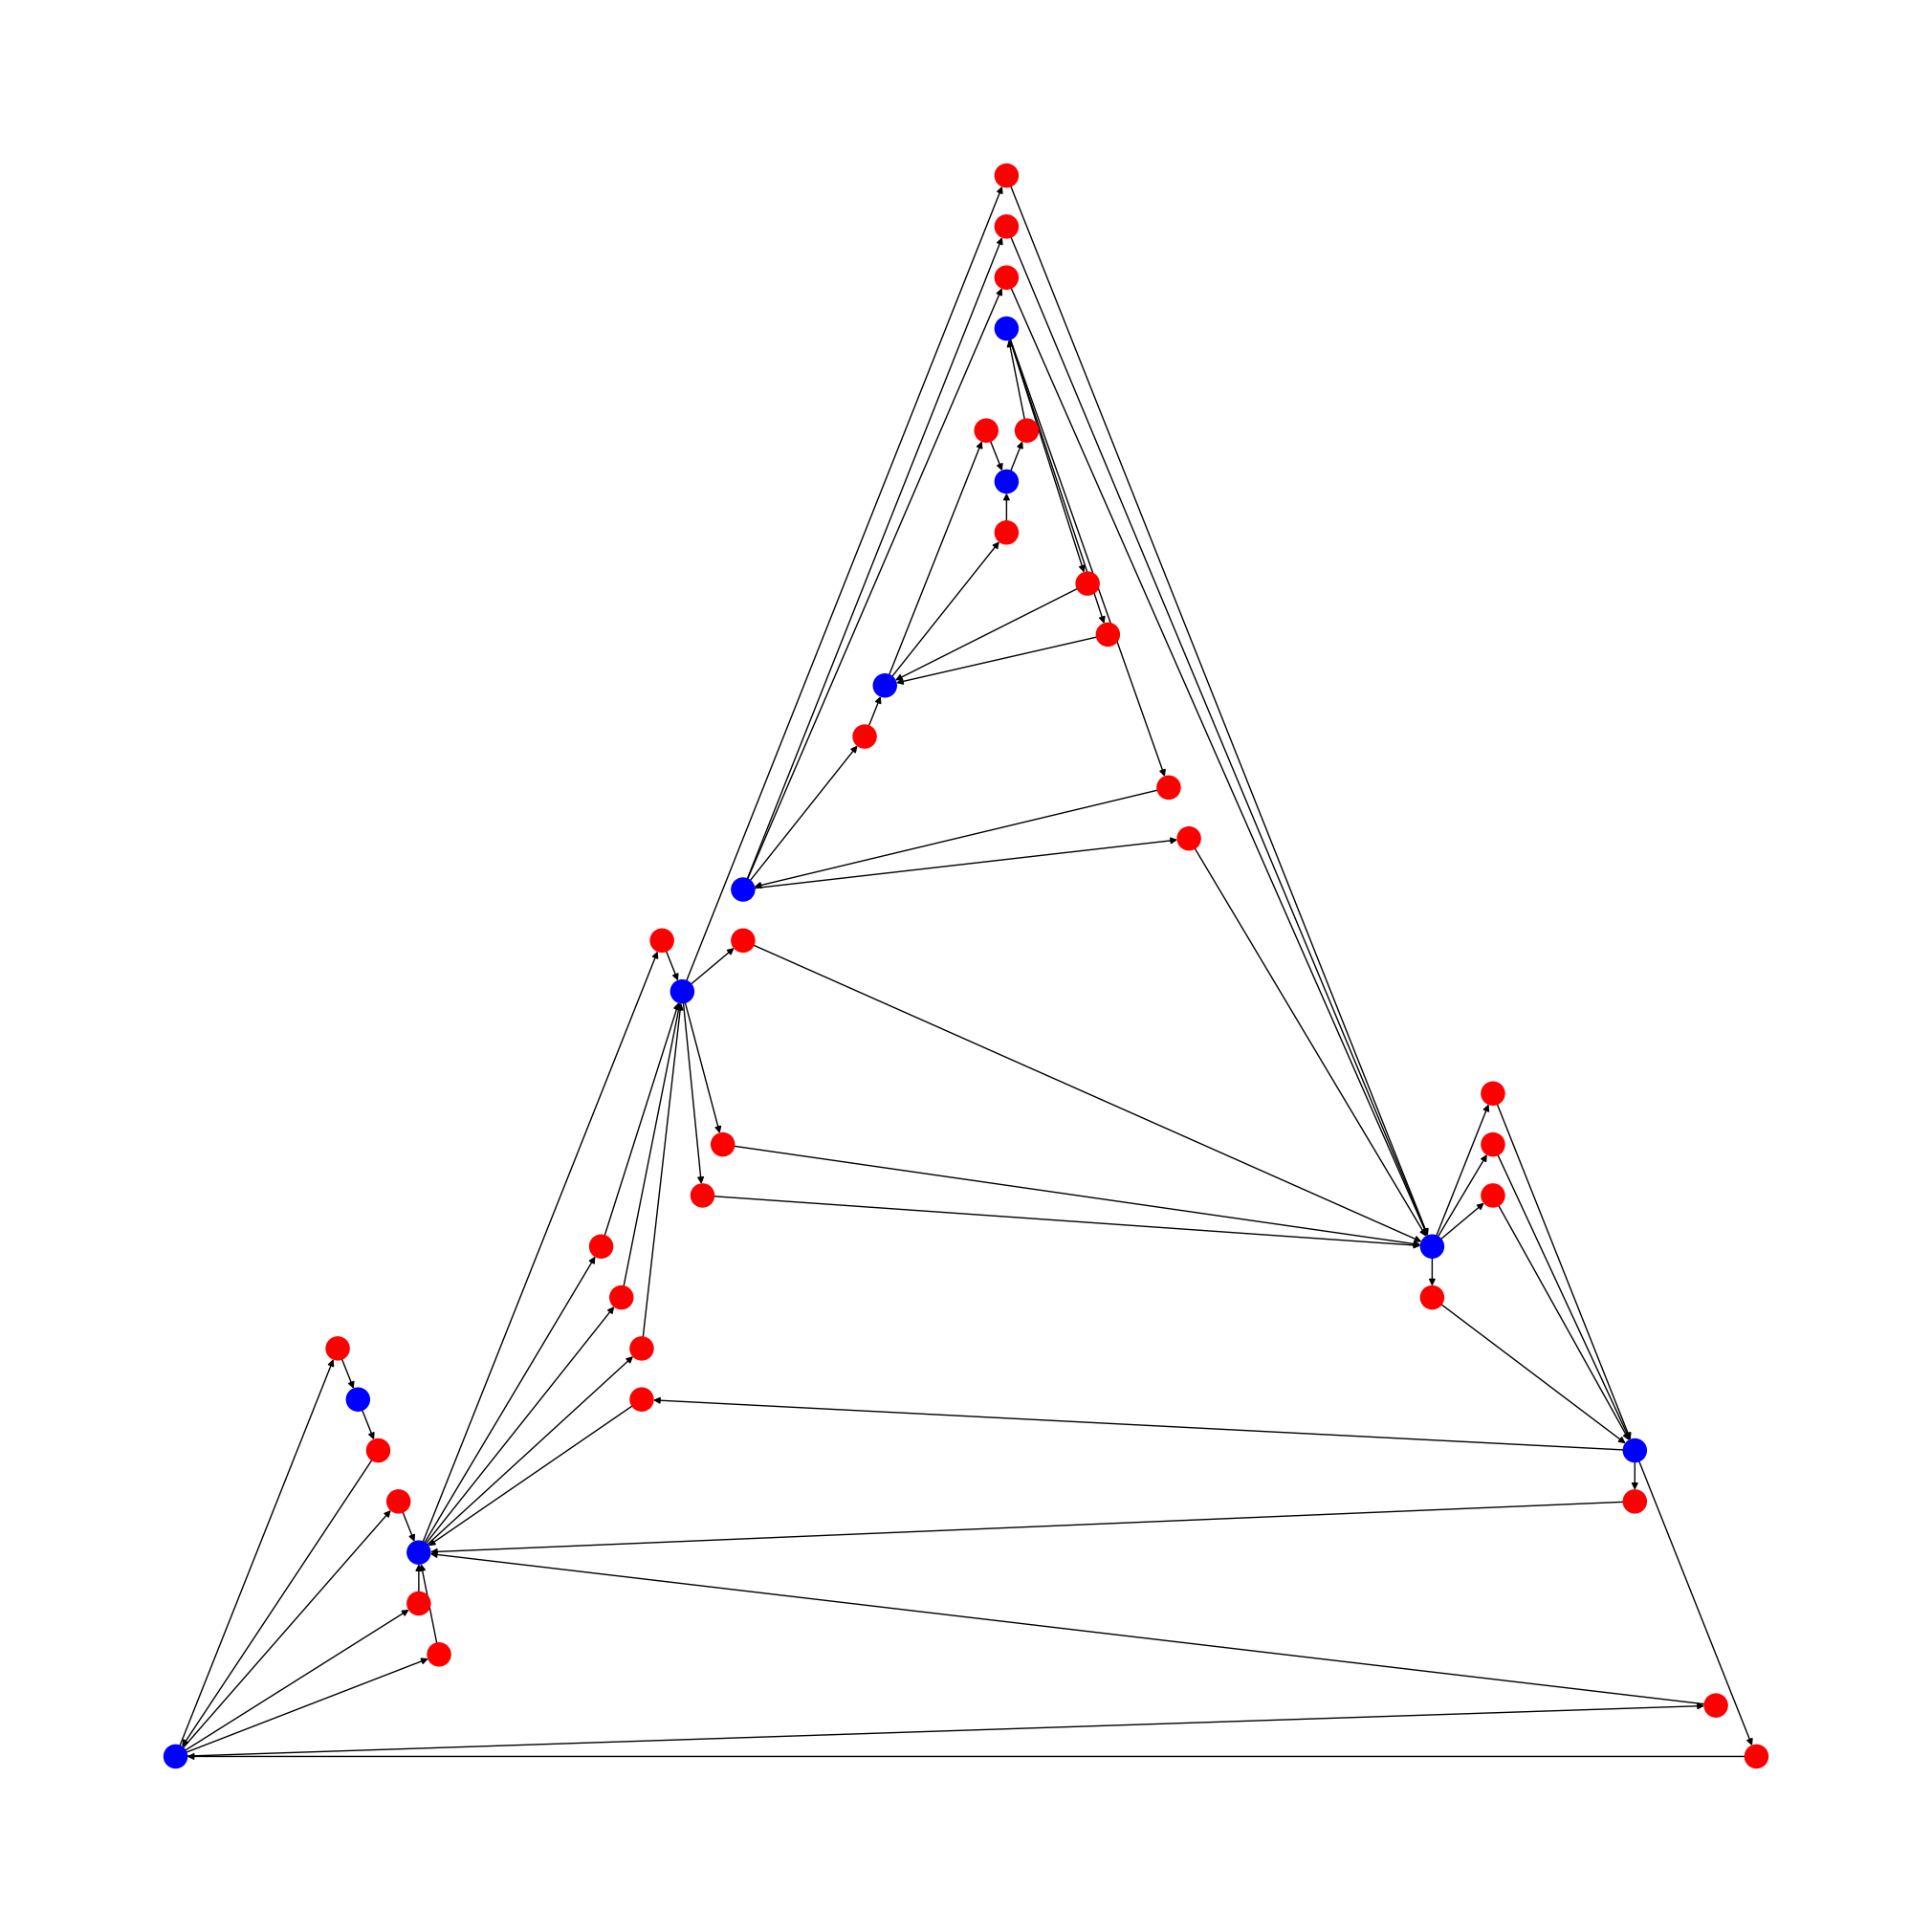

In [6]:
import matplotlib.pyplot as plt
query = """
MATCH (a: Area),
      (b: Area),
      (a)-[ca:IS_CONNECTED]->(),
      ()-[cb:IS_CONNECTED]->(b),
       p = shortestPath((a)-[:IS_CONNECTED*]->(b))
WHERE a <> b AND ca.dungeon_name = cb.dungeon_name
RETURN a.name as source, b.name as target, ca.dungeon_name as dungeon_name
"""
data = pd.DataFrame(run_query(query))
G = nx.DiGraph()
# Tripartite graph area -> dungeon -> area
for i, row in enumerate(data.itertuples()):
    source_node = {'name': row.source, 'type': 'area1'}
    target_node = {'name': row.target, 'type': 'area2'}
    dungeon_node = {'name': row.dungeon_name, 'type': 'dungeon'}
    G.add_node(row.source, **source_node)
    G.add_node(row.target, **target_node)
    G.add_node(row.dungeon_name, **dungeon_node)
    G.add_edge(row.source, row.dungeon_name)
    G.add_edge(row.dungeon_name, row.target)

# Set the position of each node 
# color = ['blue' if node[1]['type'] in ['area1', 'area2'] else 'green' for node in G.nodes(data=True)]
color = {node[0]: 'blue' if node[1]['type'] in ['area1', 'area2'] else 'red' for node in G.nodes(data=True)}

pos = nx.planar_layout(G)

plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=False, node_color=color.values(), pos=pos, font_size=10)

In [7]:
for node in G.nodes:
    G.nodes[node]['x'] = pos[node][0]
    G.nodes[node]['y'] = pos[node][1]
    G.nodes[node]['color'] = color[node]
    if color[node] == 'red':
        G.nodes[node]['shape'] = 'box'
net = Network(notebook=True, directed=True)
net.from_nx(G)
net.show("graph.html", notebook=True)


graph.html


In [8]:
query = """
MATCH (a: Area),
      (b: Area),
      (a)-[ca:IS_CONNECTED]->(),
      ()-[cb:IS_CONNECTED]->(b),
       p = shortestPath((a)-[:IS_CONNECTED*]->(b))
WHERE a <> b AND ca.dungeon_name = cb.dungeon_name
RETURN a.name as source, b.name as target, ca.dungeon_name as dungeon_name
"""
data = pd.DataFrame(run_query(query))


### 3. **Mini-mapa mazmorra**: Dada una mazmorra el mini mapa debe mostrar información que ayude a los aventureros a explorar la mazmorra. En el mini mapa debe ser fácil reconocer las entradas y las salidas de una mazmorra. Los pasillos que llevan a salas interesantes. Las zonas donde hay monstruos o tesoros y el nivel/precio de estos

In [9]:
import matplotlib.pyplot as plt
mazmorra = "Bentclock, Laboratory of the Sexy Thieves"
query_dungeon_map = """
MATCH (r1: Room{dungeon_name: $mazmorra})-[:IS_CONNECTED]->(r2: Room{dungeon_name: $mazmorra})
RETURN r1.room_name as source, r2.room_name as target
"""
data = pd.DataFrame(run_query(query_dungeon_map, mazmorra=mazmorra))
query_entry_exit = """
MATCH (a: Area)-[:IS_CONNECTED]->(r_entry: Room{dungeon_name: $mazmorra}),
        (r_exit: Room{dungeon_name: $mazmorra})-[:IS_CONNECTED]->(b: Area)
RETURN r_entry.room_name as entry, r_exit.room_name as exit
"""
entry_exit = run_query(query_entry_exit, mazmorra=mazmorra)[0]
query_monsters = """
MATCH (r: Room{dungeon_name: $mazmorra})-[c_m:CONTAINS]->(m: Monster)
RETURN r.room_name as room, m.name as monster, c_m.amount as amount_monsters
"""
monsters = pd.DataFrame(run_query(query_monsters, mazmorra=mazmorra))
query_loot = """
MATCH (r: Room{dungeon_name: $mazmorra})-[c_l:CONTAINS]->(l: Loot)
RETURN r.room_name as room, l.name as loot, c_l.amount as amount_loot
"""
query_max_level = """
MATCH (r: Room{dungeon_name: $mazmorra})-[:CONTAINS]->(m: Monster)
RETURN r.room_name as room, max(m.level) as max_level
"""
max_level = pd.DataFrame(run_query(query_max_level, mazmorra=mazmorra))
query_max_gold = """
MATCH (r: Room{dungeon_name: $mazmorra})-[:CONTAINS]->(l: Loot)
RETURN r.room_name as room, max(l.gold) as max_gold
"""
max_gold = pd.DataFrame(run_query(query_max_gold, mazmorra=mazmorra))
loot = pd.DataFrame(run_query(query_loot, mazmorra=mazmorra))
G = nx.Graph()
for i, row in enumerate(data.itertuples()):
    G.add_edge(row.source, row.target)

for node in G.nodes:
    G.nodes[node]['entry'] = False
    G.nodes[node]['exit'] = False
    if node == entry_exit['entry']:
        G.nodes[node]['entry'] = True
    if node == entry_exit['exit']:
        G.nodes[node]['exit'] = True
    max_level_row = max_level[max_level['room'] == node]
    if not max_level_row.empty:
        G.nodes[node]['max_level'] = int(max_level_row['max_level'].values[0])
    else:
        G.nodes[node]['max_level'] = 0
    max_gold_row = max_gold[max_gold['room'] == node]
    if not max_gold_row.empty:
        G.nodes[node]['max_gold'] = int(max_gold_row['max_gold'].values[0])
    else:
        G.nodes[node]['max_gold'] = 0
        

pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(20, 20))
#nx.draw(G, with_labels=False, pos=pos, font_size=10)

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

In [10]:
G.nodes['fancy observatory of werewolves']

{'entry': False, 'exit': False, 'max_level': 0, 'max_gold': 0}

In [11]:
import numpy as np

/opt/conda/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


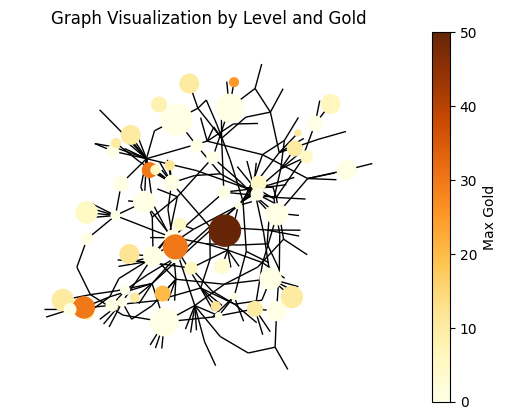

In [12]:
# Crear figura y ejes
fig, ax = plt.subplots()

# Posiciones para los nodos usando spring layout
pos = nx.spring_layout(G)

# Normalizar los valores para el tamaño y el color
levels = np.array([data['max_level'] for _, data in G.nodes(data=True)])
gold_values = np.array([data['max_gold'] for _, data in G.nodes(data=True)])
size = 500 * (levels / max(levels))  # Tamaño de los nodos
gold_colors = plt.cm.YlOrBr(gold_values / max(gold_values))  # Colores de los nodos

# Dibujar el grafo
nx.draw(G, pos, node_size=size, node_color=gold_colors, with_labels=False, cmap=plt.cm.YlOrBr, ax=ax)

# Crear un mappable para la colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrBr, norm=plt.Normalize(vmin=min(gold_values), vmax=max(gold_values)))
sm.set_array([])

# Añadir la colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Max Gold')

# Título y mostrar el gráfico
plt.title('Graph Visualization by Level and Gold')
plt.show()

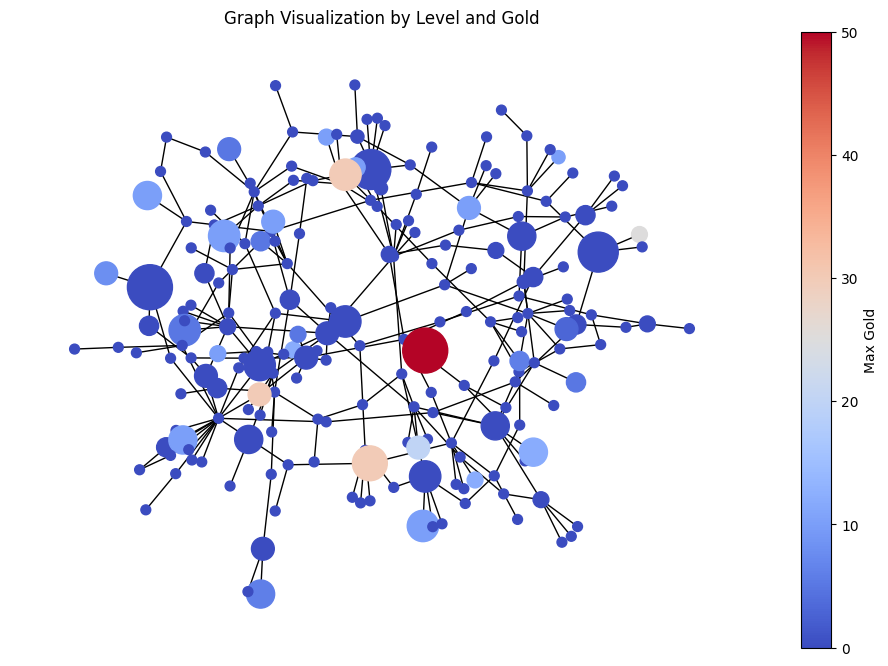

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Crear figura y ejes con un tamaño más grande
fig, ax = plt.subplots(figsize=(12, 8))  # Ajustar el tamaño de la figura aquí

# Posiciones para los nodos usando spring layout
pos = nx.spring_layout(G)

# Obtener los valores de 'max_level' y 'max_gold' para todos los nodos
levels = np.array([data['max_level'] for _, data in G.nodes(data=True)])
gold_values = np.array([data['max_gold'] for _, data in G.nodes(data=True)])

# Escalamos 'levels' para el tamaño del nodo, garantizando un tamaño mínimo visible
min_size = 50  # Tamaño mínimo de los nodos ajustado
size = min_size + (1000 * (levels / max(levels)))  # Escala con un tamaño base y un máximo mayor

# Ajustar la escala de colores para ir de azul a rojo
gold_colors = plt.cm.coolwarm((gold_values - min(gold_values)) / (max(gold_values) - min(gold_values)))

# Dibujar el grafo
nx.draw(G, pos, node_size=size, node_color=gold_colors, with_labels=False, cmap=plt.cm.coolwarm, ax=ax)

# Crear un mappable para la colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(gold_values), vmax=max(gold_values)))
sm.set_array([])

# Añadir la colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Max Gold')

# Título y mostrar el gráfico
plt.title('Graph Visualization by Level and Gold')
plt.show()


In [14]:
import networkx as nx
from pyvis.network import Network
import matplotlib

# Crear la instancia de Network
net = Network(height="800px", width="1000px", font_color="black", notebook=True)

# Supongamos que G es tu grafo de NetworkX y ya tiene los nodos y atributos definidos
# Aquí un ejemplo simple de cómo añadir nodos y aristas si fuera necesario
# G.add_node(1, max_level=3, max_gold=50)
# G.add_node(2, max_level=1, max_gold=5)
# G.add_node(3, max_level=5, max_gold=100)
# G.add_edge(1, 2)
# G.add_edge(2, 3)

# Obtener los valores de 'max_level' y 'max_gold'
max_level = max(nx.get_node_attributes(G, 'max_level').values())
min_gold = min(nx.get_node_attributes(G, 'max_gold').values())
max_gold = max(nx.get_node_attributes(G, 'max_gold').values())

# Añadir los nodos al objeto Network
for node, attr in G.nodes(data=True):
    size = 10 + (attr['max_level'] / max_level) * 100  # Calcular tamaño del nodo
    color_value = (attr['max_gold'] - min_gold) / (max_gold - min_gold)
    color = plt.cm.coolwarm(color_value)  # Usar matplotlib para obtener el color, luego convertirlo a formato HTML
    hex_color = matplotlib.colors.rgb2hex(color[:3])  # Convertir RGB a HEX
    net.add_node(node, size=size, color=hex_color, title=f"Gold: {attr['max_gold']}")

# Añadir las aristas al objeto Network
for edge in G.edges():
    net.add_edge(*edge)

# Opciones para hacer los nodos más fáciles de manejar y mejorar la visualización
net.toggle_physics(True)  # Activa la física para una disposición más natural
net.show_buttons(filter_=['physics'])  # Permite ajustar la física interactivamente si es necesario

# Guardar y mostrar el gráfico
net.show("graph.html", notebook=True)


graph.html


In [15]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import matplotlib

# Crear la instancia de Network
net = Network(height="800px", width="1000px", font_color="black", notebook=True)

# Supongamos que G es tu grafo de NetworkX y ya tiene los nodos y atributos definidos
# Aquí un ejemplo simple de cómo añadir nodos y aristas si fuera necesario
# G.add_node(1, max_level=3, max_gold=50, entry=False, exit=False)
# G.add_node(2, max_level=1, max_gold=5, entry=True, exit=False)
# G.add_node(3, max_level=5, max_gold=100, entry=False, exit=True)
# G.add_edge(1, 2)
# G.add_edge(2, 3)

# Obtener los valores de 'max_level' y 'max_gold'
max_level = max(nx.get_node_attributes(G, 'max_level').values())
min_gold = min(nx.get_node_attributes(G, 'max_gold').values())
max_gold = max(nx.get_node_attributes(G, 'max_gold').values())

# Tamaño estándar para nodos de entrada y salida
standard_size = 50

# Añadir los nodos al objeto Network
for node, attr in G.nodes(data=True):
    if attr['entry']:
        # Nodo de entrada: forma triangular y color amarillo
        net.add_node(node, size=standard_size, color="yellow", shape="triangle", title=f"Gold: {attr['max_gold']}")
    elif attr['exit']:
        # Nodo de salida: forma cuadrada y color verde
        net.add_node(node, size=standard_size, color="green", shape="square", title=f"Gold: {attr['max_gold']}")
    else:
        # Otros nodos: tamaño y color según 'max_level' y 'max_gold'
        size = 10 + (attr['max_level'] / max_level) * 100  # Calcular tamaño del nodo
        color_value = (attr['max_gold'] - min_gold) / (max_gold - min_gold)
        color = plt.cm.coolwarm(color_value)  # Usar matplotlib para obtener el color, luego convertirlo a formato HTML
        hex_color = matplotlib.colors.rgb2hex(color[:3])  # Convertir RGB a HEX
        net.add_node(node, size=size, color=hex_color, title=f"Gold: {attr['max_gold']}")

# Añadir las aristas al objeto Network
for edge in G.edges():
    net.add_edge(*edge)

# Opciones para hacer los nodos más fáciles de manejar y mejorar la visualización
net.toggle_physics(True)  # Activa la física para una disposición más natural
net.show_buttons(filter_=['physics'])  # Permite ajustar la física interactivamente si es necesario

# Guardar y mostrar el gráfico
net.show("graph.html", notebook=True)


graph.html


In [16]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

# Crear un mapa de colores personalizado de amarillo claro a amarillo oscuro
colors = ["#ffff66", "#4d3d00"]  # Amarillo claro a amarillo oscuro (hexadecimal)
cmap = LinearSegmentedColormap.from_list("custom_yellow", colors, N=256)

# Crear la instancia de Network
net = Network(height="800px", width="1000px", bgcolor='white' ,font_color="black", notebook=True)

# Obtener los valores de 'max_level' y 'max_gold'
max_level = max(nx.get_node_attributes(G, 'max_level').values())
min_gold = min(nx.get_node_attributes(G, 'max_gold').values())
max_gold = max(nx.get_node_attributes(G, 'max_gold').values())

# Tamaño estándar para nodos de entrada y salida
standard_size = 30

# Añadir los nodos al objeto Network
for node, attr in G.nodes(data=True):
    if attr['entry']:
        # Nodo de entrada: forma triangular y color amarillo
        net.add_node(node, size=standard_size, color="red", shape="square", title=f"Gold: {attr['max_gold']}")
    elif attr['exit']:
        # Nodo de salida: forma cuadrada y color verde
        net.add_node(node, size=standard_size, color="green", shape="square", title=f"Gold: {attr['max_gold']}")
    else:
        # Otros nodos: tamaño y color según 'max_level' y 'max_gold'
        size = 10 + (attr['max_level'] / max_level) * 100  # Calcular tamaño del nodo
        color_value = (attr['max_gold'] - min_gold) / (max_gold - min_gold)
        color = cmap(color_value)  # Usar el mapa de colores personalizado para obtener el color
        hex_color = matplotlib.colors.rgb2hex(color)  # Convertir RGB a HEX
        net.add_node(node, size=size, color=hex_color, title=f"Gold: {attr['max_gold']}")

# Añadir las aristas al objeto Network
for edge in G.edges():
    net.add_edge(*edge)

# Opciones para hacer los nodos más fáciles de manejar y mejorar la visualización
net.toggle_physics(True)  # Activa la física para una disposición más natural
net.show_buttons(filter_=['physics'])  # Permite ajustar la física interactivamente si es necesario

# Guardar y mostrar el gráfico
net.show("graph.html", notebook=True)


graph.html


In [17]:
entry_exit = run_query(query_entry_exit, mazmorra=mazmorra)

In [18]:
entry_exit

[{'entry': 'fierce treasure room ', 'exit': 'bashful ballroom '}]

In [19]:
query_entry_exit

'\nMATCH (a: Area)-[:IS_CONNECTED]->(r_entry: Room{dungeon_name: $mazmorra}),\n        (r_exit: Room{dungeon_name: $mazmorra})-[:IS_CONNECTED]->(b: Area)\nRETURN r_entry.room_name as entry, r_exit.room_name as exit\n'

In [20]:
for node in G.nodes:
    G.nodes[node]['x'] = pos[node][0]
    G.nodes[node]['y'] = pos[node][1]
    G.nodes[node]['title'] = f"""{node}
                                 Max level: {G.nodes[node]['max_level']}
                                 Max gold: {G.nodes[node]['max_gold']}"""
    if G.nodes[node]['entry']:
        G.nodes[node]['color'] = 'red'
        #G.nodes[node]['shape'] = 'image'
        #G.nodes[node]['image'] = './entrance.png'
    elif G.nodes[node]['exit']:
        G.nodes[node]['color'] = 'green'
        #G.nodes[node]['shape'] = 'image'
        #G.nodes[node]['image'] = './exit.png'
    else:
        G.nodes[node]['color'] = 'blue'
    #G.nodes[node]['shape'] = 'box'
    G.nodes[node]['label'] = str(node)
net = Network(notebook=True, directed=False)
net.from_nx(G)
for node in G.nodes:
    if G.nodes[node]['max_level'] > 0:
        net.add_node(node, image="./monster.png", shape='image')
# Disable physics
# net.toggle_physics(False)
# Disable the ability to drag the network
# net.options.interaction.dragNodes = False
net.show("graph.html", notebook=True)

graph.html


In [21]:
entry_exit

[{'entry': 'fierce treasure room ', 'exit': 'bashful ballroom '}]

In [22]:
monsters.sort_values('amount_monsters')

,room,monster,amount_monsters
0,drawing room,doppelganger,1
81,unsightly bathroom,darkmantle,1
80,vault of pirates,carrion crawler,1
79,unsightly bathroom,basilisk,1
78,obnoxious stable of hippies,basilisk,1
...,...,...,...
31,atrium of sumo wrestlers,invisible stalker,1
30,lounge of furries,intellect devourer,1
29,screeching barracks of nerds,helmed horror,1
55,agreeable lounge,driad,1


In [23]:
max_gold

50

In [24]:
max_level

50